In [1]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data_guess, to_pyg_data_true
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE
from torch.nn import Linear, Sequential, ReLU, LeakyReLU
from torch.optim import Adam

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# run only if new data is desired
ode_dim = 3
n_data = 10
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,10000)

dataset_train = []
for i in range(0,len(x_train)):
    p = param[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset_train.append(to_pyg_data_true(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset_train,batch_size=32,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    p = param_test[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset.append(to_pyg_data_true(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [3]:
from torch.nn import Linear, Sequential, LeakyReLU
from torch_geometric.nn import GATConv

class GCNEncoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels=10):
        super(GCNEncoder, self).__init__()

        self.gcn1 = GCNConv(in_channels,4*out_channels)
        self.gcn2 = GCNConv(4*out_channels,out_channels)

    def forward(self, data, edge_index):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.gcn1(x, edge_index=edge_index)
        x = torch.nn.functional.leaky_relu(x)
        x = self.gcn2(x,edge_index=edge_index)
        return torch.nn.functional.leaky_relu(x)

In [5]:
class MLPDecoder(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim=16):
        super(MLPDecoder, self).__init__()
        # Define the MLP for decoding
        self.mlp = Sequential(
            Linear(2 * embedding_dim, hidden_dim),
            LeakyReLU(),
            Linear(hidden_dim, 1)  # Output a single value (edge weight) for each pair
        )

    def forward(self, z, edge_index):
        # Extract source and target node embeddings based on edge_index
        src_nodes = z[edge_index[0]]  # Shape: (num_edges, embedding_dim)
        tgt_nodes = z[edge_index[1]]  # Shape: (num_edges, embedding_dim)

        # Concatenate source and target embeddings for each pair
        edge_features = torch.cat([src_nodes, tgt_nodes], dim=-1)  # Shape: (num_nodes, num_nodes, 2 * embedding_dim)

        # Pass through MLP to predict edge weights
        edge_weights = self.mlp(edge_features).squeeze(-1)  # Shape: (num_nodes, num_nodes)

        return edge_weights

In [6]:
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import to_dense_adj

model = GAE(GCNEncoder(2*n_data,30),MLPDecoder(30))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = torch.nn.MSELoss()

train_loss = []

for epoch in range(3000):
    model.train()

    tr_loss = 0
    full_loss = 0
    for data in loader:
        data = data.to(device)
        batch_size = data.batch.max().item()+1
        optimizer.zero_grad()

        z = model.encode(data, data.edge_index)

        recon_part = model.decode(z,data.edge_index)

        loss = criterion(recon_part,data.edge_attr.flatten())

        train_loss.append(loss)
        full_loss += loss

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

        with torch.no_grad():
            latent_embeddings = z.cpu().detach().numpy()
    #train_loss.append(full_loss)
    print(full_loss.item())

for data in dataset_train:
    z = model.encode(data.to(device), data.edge_index)

    recon = model.decode(z,data.edge_index)

    print(recon)

941.415283203125
900.0684204101562
861.9000244140625
841.1653442382812
862.4761352539062
840.5008544921875
835.75927734375
831.2882080078125
832.4871826171875
832.2321166992188
831.0963134765625
826.28369140625
827.5108642578125
829.689453125
829.3765869140625
835.2410278320312
825.357421875
823.6434326171875
823.1543579101562
820.6925048828125
822.8604736328125
816.6679077148438
817.7357177734375
817.7030029296875
815.2405395507812
811.9149169921875
813.7101440429688
811.5003051757812
813.1697998046875
812.8682250976562
811.2557983398438
808.0534057617188
805.8651123046875
806.1448364257812
804.6521606445312
802.6939086914062
802.0729370117188
801.4234008789062
801.2215576171875
798.3842163085938
798.1437377929688
794.7799682617188
794.40380859375
799.88232421875
792.970947265625
790.5897827148438
796.5386352539062
790.2681274414062
788.2254028320312
787.7691650390625
787.6986083984375
784.1619873046875
784.2896728515625
782.9150390625
783.9849853515625
781.1033325195312
778.608154296

KeyboardInterrupt: 

(30000, 30)


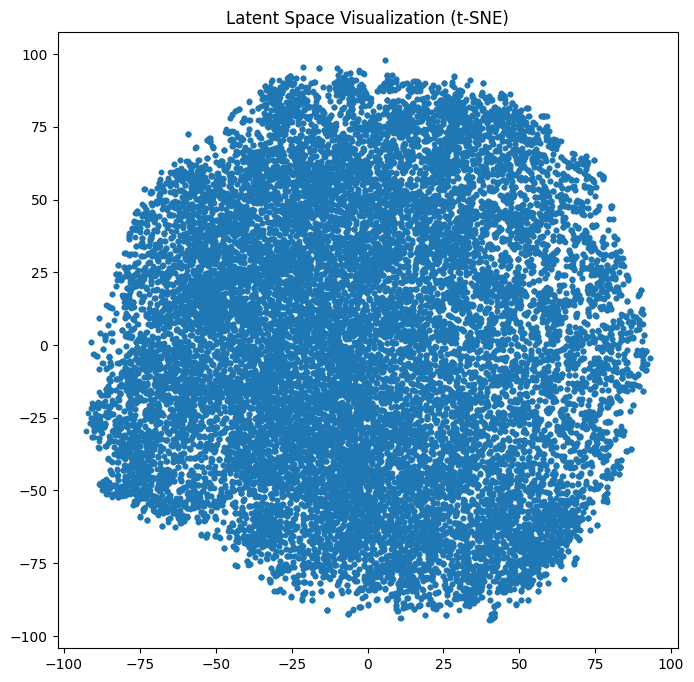

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

latent_embeddings =  torch.tensor(1)

for data in loader:
        data = data.to(device)
        z = model.encode(data, data.edge_index)

        with torch.no_grad():
            if len(latent_embeddings.shape) == 0:
                 latent_embeddings = z
            else:
                latent_embeddings = torch.cat((latent_embeddings,z))

latent_embeddings = latent_embeddings.cpu().detach().numpy()
print(latent_embeddings.shape)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(latent_embeddings)

plt.figure(figsize=(8, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)
plt.title("Latent Space Visualization (t-SNE)")
plt.show()

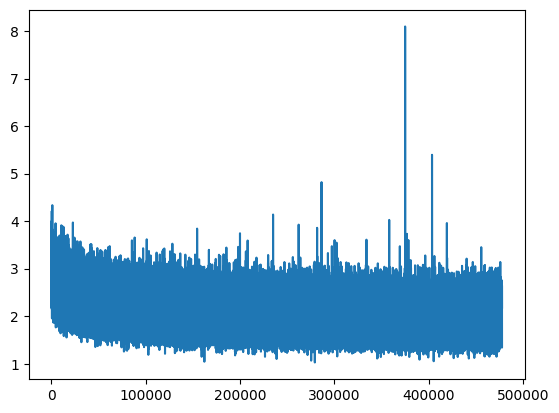

In [21]:
import matplotlib.pyplot as plt

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.show()

In [22]:
def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,100)

val_dataset = []
param_list = []

for i in range(0,len(x_val)):
    p = param_val[i]
    param_vec = torch.cat((p.Win.flatten(), p.Wout.flatten(), p.bin, p.bout, p.gamma)).numpy()
    param_list.append(param_vec)
    val_dataset.append(to_pyg_data_true(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset,batch_size=1)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

changed = 0
fixed = 0
destroyed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    batch = batch.to(device)
    z = model.encode(batch, batch.edge_index)
    
    recon = model.decode(z,batch.edge_index)
    Ahat = recon.flatten()

    print(batch.edge_attr)
    print(Ahat)

    # Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.edge_attr)
    Ahat = get_adjacency(Ahat)
    print(Ahat)
    print(A)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1

    for i in range(0,len(A)):

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1   
            
        elems_total += 1

print(correct/total)
print(elem_wise/elems_total)

tensor([-0.6345, -0.6165, -1.3022], device='cuda:0')
tensor([-0.8749, -0.8749, -0.4054], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([0., 0., 0.], device='cuda:0', dtype=torch.float64)
tensor([ 0.,  0., -1.], device='cuda:0', dtype=torch.float64)
tensor([ 2.1367, -1.5004,  0.6800, -1.3952], device='cuda:0')
tensor([-0.4520,  0.5553, -0.2827,  1.0412], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([0., 0., 0., 1.], device='cuda:0', dtype=torch.float64)
tensor([ 1., -1.,  0., -1.], device='cuda:0', dtype=torch.float64)
tensor([-2.8274, -1.4688, -1.4822,  3.1321], device='cuda:0')
tensor([-0.0712, -0.7861, -0.3982, -0.1293], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 0., -1., -1.,  0.], device='cuda:0', dtype=torch.float64)
tensor([-1.,  0.,  0.,  1.], device='cuda:0', dtype=torch.float64)
tensor([-1.8570, -1.1797, -0.6615, -2.1284, -0.8458], device='cuda:0')
tensor([-1.0838, -1.0838, -0.6776, -1.0838, -0.5283], device='cuda:0',
       grad_fn